# Two-wave algorithm


In [11]:
import numpy as np
from rashomon import loss
from rashomon.aggregate import raggregate
import visualizations
from rashomon.hasse import policy_to_profile, enumerate_policies, enumerate_profiles
from rashomon.aggregate import RAggregate
from datagen import phi_basic, generate_data_from_assignments
from boundary import (
    compute_boundary_probabilities, get_allocations,
    create_assignments_from_alloc
)
from rashomon.extract_pools import extract_pools, aggregate_pools
from rashomon.loss import compute_pool_means, compute_policy_means
from rashomon.metrics import make_predictions
from rashomon.extract_pools import lattice_edges

import numpy as np
import matplotlib.pyplot as plt

In [13]:
M = 5  # number of features
R = np.array([4, 3, 3, 2, 3])  # levels per feature
lambda_reg = 0.001  # reg parameter
epsilon = 0.05  # tolerance off MAP
n = (100, 100) # units per wave
H = np.inf

sig = 1.0

verbose = True
adaptive = False

num_workers = 2

In [14]:
# enumerate all policies and profiles
all_policies = enumerate_policies(M, R)
num_policies = len(all_policies)
profiles, profile_map = enumerate_profiles(M)
num_profiles = len(profiles)


# profile index mappings
policies_profiles = {}
policies_ids_profiles = {}
policies_profiles_masked = {} # the masked policies just hold the active features
for k, profile in enumerate(profiles):
    ids = [i for i, p in enumerate(all_policies) if policy_to_profile(p) == profile]
    policies_ids_profiles[k] = ids
    policies_profiles[k] = [all_policies[i] for i in ids]

    profile_mask = [bool(v) for v in profile]  # t/f map of which features are active
    masked_policies = [tuple([pol[i] for i in range(M) if profile_mask[i]]) for pol in
                       policies_profiles[k]]
    policies_profiles_masked[k] = masked_policies

lattice_edges = lattice_edges(all_policies)

neighbors = {i: [] for i in range(len(all_policies))}
for i, j in lattice_edges:
    neighbors[i].append(j)
    neighbors[j].append(i)  # edges are undirected

In [15]:
# vector of true policy outcomes
oracle_outcomes = np.array([phi_basic(p) for p in all_policies])

# oracle rank mapped to policy index (so index 0 gives the best policy index)
oracle_rank_to_policy = np.argsort(-oracle_outcomes)

# policy index mapped to oracle rank (so index 0 gives oracle rank for first policy 0)
oracle_policy_to_rank = np.empty_like(oracle_rank_to_policy)
oracle_policy_to_rank[oracle_rank_to_policy] = np.arange(1, len(oracle_outcomes)+1)

# top-k indices, policies, and values
top_k = 10
top_k_indices = oracle_rank_to_policy[:top_k]
top_k_policies = [all_policies[i] for i in top_k_indices]
top_k_values = oracle_outcomes[top_k_indices]

# overview of the rank, index, and profiles of the top policies
if verbose:
    print("Top-k best policies and their profiles:")
    for rank, idx in enumerate(top_k_indices, 1):
        policy = all_policies[idx]
        profile = policy_to_profile(policy)
        print(f"Rank {rank}: Policy idx {idx}, Policy {[int(i) for i in policy]}, Profile {profile}")

Top-k best policies and their profiles:
Rank 1: Policy idx 215, Policy [3, 2, 2, 1, 2], Profile (1, 1, 1, 1, 1)
Rank 2: Policy idx 213, Policy [3, 2, 2, 1, 0], Profile (1, 1, 1, 1, 0)
Rank 3: Policy idx 214, Policy [3, 2, 2, 1, 1], Profile (1, 1, 1, 1, 1)
Rank 4: Policy idx 212, Policy [3, 2, 2, 0, 2], Profile (1, 1, 1, 0, 1)
Rank 5: Policy idx 211, Policy [3, 2, 2, 0, 1], Profile (1, 1, 1, 0, 1)
Rank 6: Policy idx 210, Policy [3, 2, 2, 0, 0], Profile (1, 1, 1, 0, 0)
Rank 7: Policy idx 197, Policy [3, 1, 2, 1, 2], Profile (1, 1, 1, 1, 1)
Rank 8: Policy idx 196, Policy [3, 1, 2, 1, 1], Profile (1, 1, 1, 1, 1)
Rank 9: Policy idx 195, Policy [3, 1, 2, 1, 0], Profile (1, 1, 1, 1, 0)
Rank 10: Policy idx 192, Policy [3, 1, 2, 0, 0], Profile (1, 1, 1, 0, 0)


In [16]:
wave_number = 1

In [17]:
boundary_probs = np.ndarray(shape=(num_policies,), dtype=float)

if wave_number == 1:
    # initialize using theoretical boundary probabilities using equation
    boundary_probs = compute_boundary_probabilities(all_policies, R, H)

In [18]:
# integer allocation across all policies, sums to n1
alloc = get_allocations(boundary_probs, n[wave_number])
assert(alloc.sum() == n[wave_number])

# generate assignments for wave 1
D = create_assignments_from_alloc(alloc) # shape (n1, 1)
X, y = generate_data_from_assignments(D, all_policies, oracle_outcomes, sig=sig)

In [19]:
# policy_stats is a 2D array - [sum of all values for that policy, number of policies added]. If the count value is zero, then that policy was unobserved.
policy_stats = compute_policy_means(D, y, num_policies)

observed_policy_indices = np.where(policy_stats[:, 1] > 0)[0]
unobserved_policy_indices = np.where(policy_stats[:, 1] == 0)[0]

observed_profiles = {
    k for k, ids in policies_ids_profiles.items()
    if np.any(policy_stats[ids, 1] > 0)
}
unobserved_profiles = set(policies_ids_profiles.keys()) - observed_profiles

observed_policies_per_profile = {
    k: list(set(ids) & set(observed_policy_indices))
    for k, ids in policies_ids_profiles.items()
}

policy_observation_density = {
    k: len(observed_policies_per_profile.get(k, [])) / len(policies_ids_profiles[k])
    for k in policies_ids_profiles
}

In [20]:
theta_init = 0
theta_step = 0.005
max_rset_size = 100000  # desired minimum number of feasible combinations

theta = theta_init
R_set = []
R_profiles = []

while len(R_set) <= max_rset_size:
    R_set, R_profiles = RAggregate(
        M, R, H, D, y, theta,
        reg=lambda_reg, num_workers=num_workers, verbose=False
    )
    if verbose:
        print(f"Theta: {theta:.4f} -- RPS size: {len(R_set)}")
    if len(R_set) >= max_rset_size: break
    theta += theta_step

if len(R_set) == 0:
    print("Warning: No feasible Rashomon set found within range.")
elif verbose:
    print(f"End theta: {theta:.4f}, RPS size: {len(R_set)}")

Theta: 0.0000 -- RPS size: 0
Theta: 0.0050 -- RPS size: 0
Theta: 0.0100 -- RPS size: 0
Theta: 0.0150 -- RPS size: 0
Theta: 0.0200 -- RPS size: 0
Theta: 0.0250 -- RPS size: 0
Theta: 0.0300 -- RPS size: 0
Theta: 0.0350 -- RPS size: 0
Theta: 0.0400 -- RPS size: 0
Theta: 0.0450 -- RPS size: 0
Theta: 0.0500 -- RPS size: 0
Theta: 0.0550 -- RPS size: 0
Theta: 0.0600 -- RPS size: 0
Theta: 0.0650 -- RPS size: 0
Theta: 0.0700 -- RPS size: 0
Theta: 0.0750 -- RPS size: 0
Theta: 0.0800 -- RPS size: 0
Theta: 0.0850 -- RPS size: 0
Theta: 0.0900 -- RPS size: 0
Theta: 0.0950 -- RPS size: 0
Theta: 0.1000 -- RPS size: 0
Theta: 0.1050 -- RPS size: 0
Theta: 0.1100 -- RPS size: 0
Theta: 0.1150 -- RPS size: 0
Theta: 0.1200 -- RPS size: 0
Theta: 0.1250 -- RPS size: 0
Theta: 0.1300 -- RPS size: 0
Theta: 0.1350 -- RPS size: 0
Theta: 0.1400 -- RPS size: 861
Theta: 0.1450 -- RPS size: 56971
Theta: 0.1500 -- RPS size: 713584
End theta: 0.1500, RPS size: 713584


In [22]:
# set theta
theta = 0.141
R_set, R_profiles = RAggregate(
    M, R, H, D, y, theta,
    reg=lambda_reg, num_workers=num_workers, verbose=False
)
if verbose:
    print(f"First-wave Rashomon set: {len(R_set)} feasible global partitions (combinations of per-profile poolings).")

First-wave Rashomon set: 2447 feasible global partitions (combinations of per-profile poolings).


In [24]:
num_partitions = len(R_set)
boundary_matrix = np.zeros((num_partitions, num_policies), dtype=int) # TODO check zeros here and boundary logic

regrets = []
contains_best = []
best_pred_indices_all = []
policy_indices_all = []
policy_means_all = []
partition_losses = np.zeros(num_partitions)

sorted_idx_all = []
sorted_means_all = []

# track pools for each profile k, for each rashomon set r
for r, r_set in enumerate(R_set):
    pi_policies_profiles_r = {}

    for k, profile in enumerate(profiles):
        sigma_k = R_profiles[k].sigma[r_set[k]]
        if sigma_k is None:
            # the entire profile is just one pool, so we map all policies to single pool 0.
            n_policies_profile = len(policies_profiles_masked[k])
            pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
        else:
            _, pi_policies_r_k = extract_pools(policies_profiles_masked[k], sigma_k)

        # each profile (0-indexed) holds a dictionary of each of the included policies (locally 0-indexed, can be remapped with helpers), and indicates assignment to local pool number
        pi_policies_profiles_r[k] = pi_policies_r_k

    # aggregate into global partition structures
    pi_pools_r, pi_policies_r = aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = compute_pool_means(policy_stats, pi_pools_r)

    # track loss for this partition (for posterior weights)
    partition_losses[r] = sum(R_profiles[k].loss[r_set[k]] for k in range(len(r_set)))

    # compute predictions by policy
    policy_indices = np.array(list(pi_policies_r.keys()))
    policy_means = np.array([pool_means_r[pi_policies_r[idx]] for idx in policy_indices])
    policy_indices_all.append(policy_indices)
    policy_means_all.append(policy_means)

    # sort and evaluate
    order = np.argsort(-policy_means)
    sorted_idx = policy_indices[order]
    sorted_means = policy_means[order]
    sorted_idx_all.append(sorted_idx)
    sorted_means_all.append(sorted_means)

    # estimate outcomes for the partition
    y_r_est = make_predictions(D, pi_policies_r, pool_means_r)

    # track boundary structure
    for i in range(num_policies):
        pool_i = pi_policies_r.get(i, -1)
        count = 0
        for nb in neighbors[i]:
            pool_nb = pi_policies_r.get(nb, -1)
            if pool_nb != -1 and pool_nb != pool_i:
                count += 1
        boundary_matrix[r, i] = count

In [25]:
# Post-process: posterior weights and MAP
posterior_weights = np.exp(-partition_losses)
posterior_weights /= posterior_weights.sum() if posterior_weights.sum() > 0 else 1.0
map_idx = np.argmin(partition_losses)
map_loss = partition_losses[map_idx]

# Extract MAP partition
map_idx = np.argmin(partition_losses)
sorted_idx = sorted_idx_all[map_idx]
sorted_means = sorted_means_all[map_idx]
top_idx = top_k_indices[0]

# get T/F mask of the matrix of counts of number of boundaries
binary_boundary_matrix = (boundary_matrix > 0).astype(float)
posterior_boundary_probs = np.average(binary_boundary_matrix, axis=0, weights=posterior_weights)
# to avoid small numerical errors, round to 8 decimal
posterior_boundary_probs = np.round(posterior_boundary_probs, decimals=8)

In [26]:
# Posterior-weighted average regret (top-1 regret per partition)
posterior_regrets = []
for sorted_idx in sorted_idx_all:
    best_pred = sorted_idx[0]
    regret = float(oracle_outcomes[top_k_indices[0]] - oracle_outcomes[best_pred])
    posterior_regrets.append(regret)
posterior_expected_regret = np.dot(posterior_weights, posterior_regrets)

In [34]:
policy_indices = policy_indices_all[map_idx]
policy_means = policy_means_all[map_idx]
order = np.argsort(-policy_means)

n_preview = num_policies

sorted_idx = policy_indices[order][:n_preview]
sorted_means = policy_means[order][:n_preview]
oracle_values = oracle_outcomes[sorted_idx]
oracle_ranks = oracle_policy_to_rank[sorted_idx]
is_topk = [i in top_k_indices for i in sorted_idx]

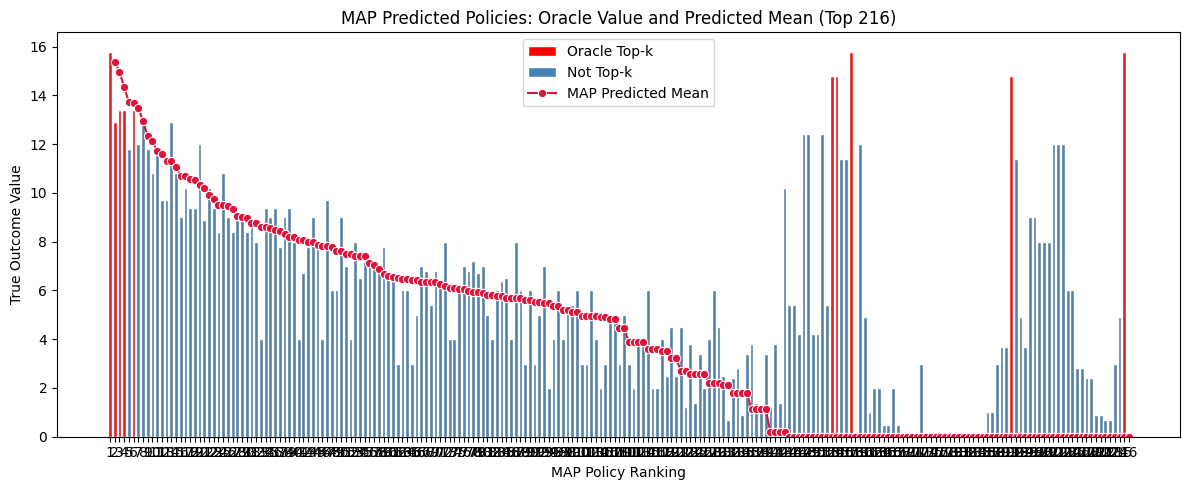

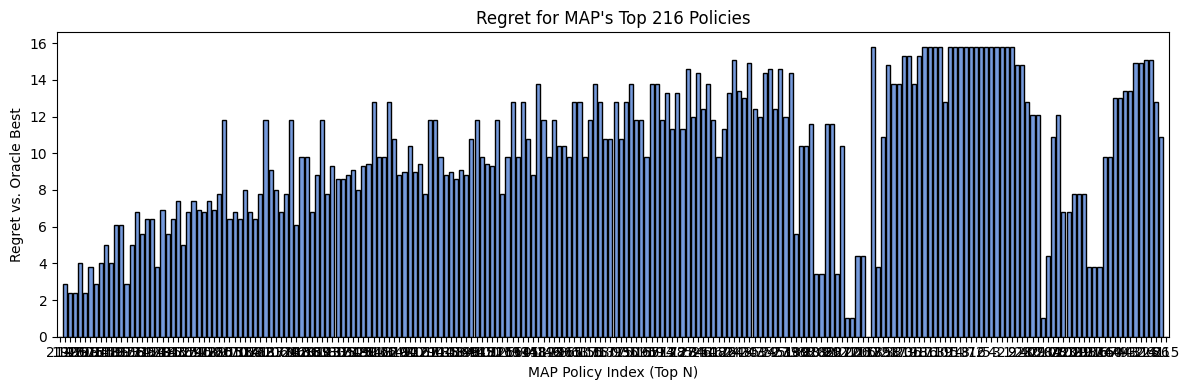

MAP top-216 min regret: 0.000  max regret: 15.800
Regression results: R2 = 0.276, Slope = 0.54, Intercept = 1.17


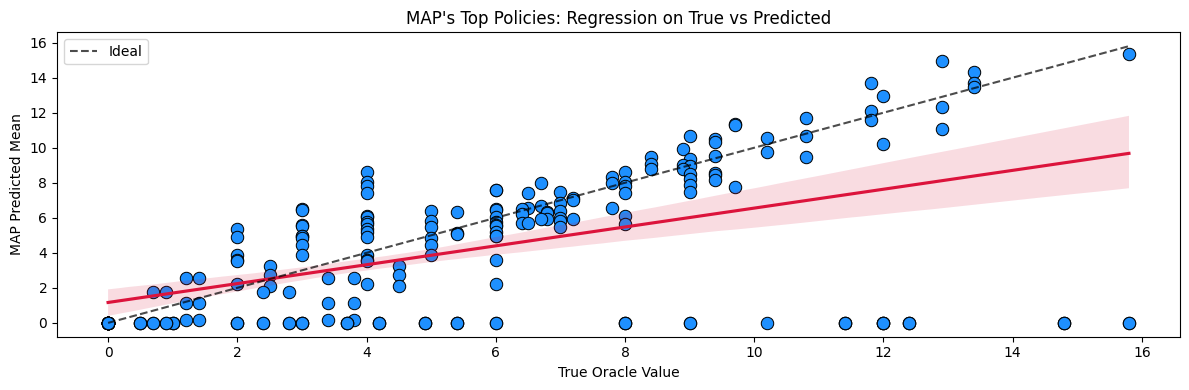

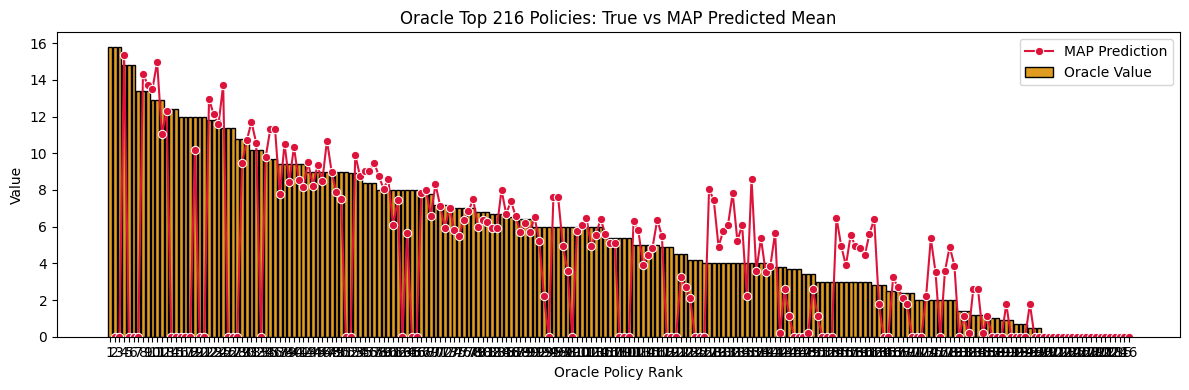

Oracle top-216 min/max regret (MAP predicted minus true): -4.616 / 15.800


In [35]:
# -- MAP Summary and Regret Plots --
df_map = visualizations.plot_map_true_vs_predicted_bar(
    sorted_idx=sorted_idx,
    sorted_means=sorted_means,
    oracle_beta=oracle_outcomes,
    oracle_ranks=oracle_policy_to_rank,
    top_k_indices=top_k_indices,
    N=n_preview
)
visualizations.plot_map_regret_bar(sorted_idx, oracle_outcomes, top_idx, N=n_preview)
visualizations.plot_map_regression(df_map)
visualizations.plot_oracle_ordered_bar(df_map, top_k_indices, oracle_outcomes, all_policies, N=n_preview)

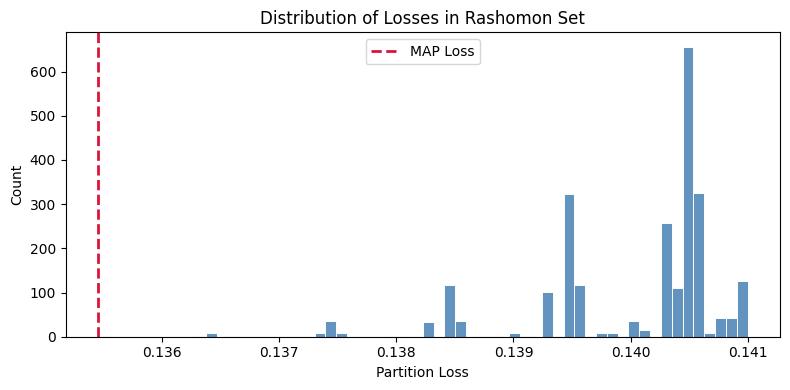

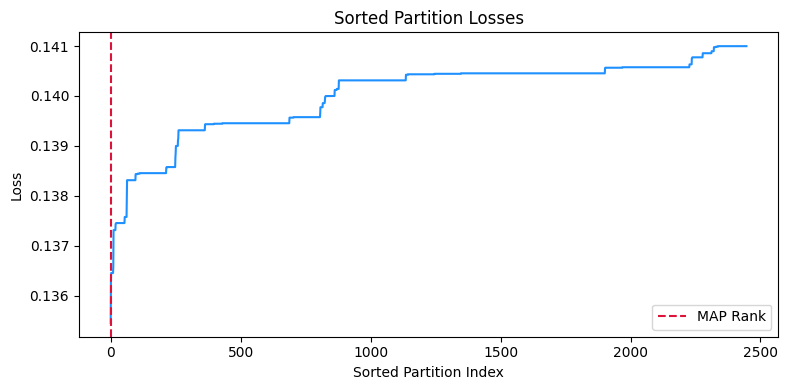

In [36]:
# -- Loss Distribution Plots --
visualizations.plot_rps_loss_histogram_v2(partition_losses, map_idx, bins=60, show_kde=False)
visualizations.plot_rps_loss_curve(partition_losses, map_idx)

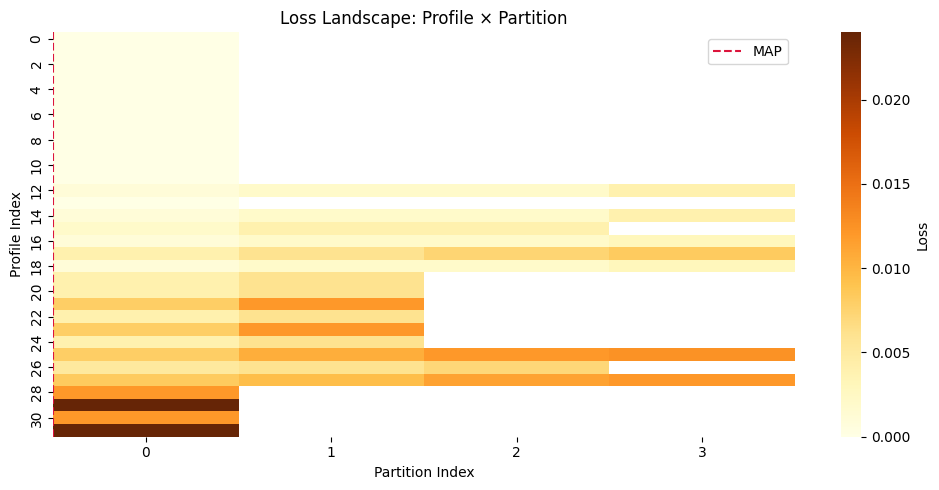

Number of partitions per profile (should match): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 3, 4, 1, 1, 1, 1]


In [38]:
# -- Partition × Profile Loss Matrix --
profile_losses = [rp.loss for rp in R_profiles]
visualizations.plot_minimax_risk_matrix(profile_losses, map_idx=map_idx)
print(f"Number of partitions per profile (should match): {[len(p) for p in profile_losses]}")